### Введите даты интервала в формате YYYY-MM-DD

In [15]:
from datetime import datetime
date_obj1 = datetime.fromisoformat('2021-03-01')
date_obj2 = datetime.fromisoformat('2021-06-30')

### Запуск краулера

In [2]:
from collect_news import collect_news

await collect_news(date_obj1, date_obj2)

## Задание 1. Тэги.
### Спутник: подготовка данных за интервал

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json

sptnk_data = pd.DataFrame(columns=['date', 'title', 'tags', 'url', 'author', 'text', 'img'])
sptnk_news_dir = "./news_sptnk"

for file_path in (fl for fl in os.listdir(sptnk_news_dir) if ".json" in fl):
    date = datetime.strptime(file_path.removesuffix('.json'),"%Y-%m-%d")
    if date >= date_obj1 and date <= date_obj2:
        with open(sptnk_news_dir + '/' + file_path, 'r') as file:
            contents = json.loads(file.read())
            df_item = pd.DataFrame.from_records(contents, columns=['date', 'title', 'tags', 'url', 'author', 'text', 'img'])
            sptnk_data = sptnk_data.append(df_item, ignore_index = True)

# sort news by date
sptnk_data = sptnk_data.sort_values('date', ascending=True)


### Спутник: популярные тэги

Встречаемость тегов:
Узбекистан                                                1373
Общество                                                  1362
Экономика                                                  390
Ташкент                                                    344
Политика                                                   341
                                                          ... 
фотоаппарат                                                  1
Федерация обществ защиты прав потребителей Узбекистана       1
обезьяна                                                     1
воры                                                         1
молодежный форум                                             1
Name: tags, Length: 2256, dtype: int64 

Статистика:
count          18730
unique          2256
top       Узбекистан
freq            1373
Name: tags, dtype: object 

20 самых популярных тегов:


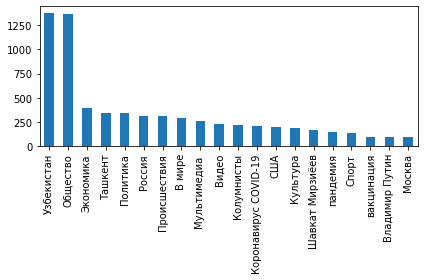

In [17]:
# take 'tags' column (list of lists of tags) and make from him one list of tags
tags = sptnk_data['tags'].explode()

# print number of tag uses (unique tag <-> count)
tags_cnt = tags.value_counts()
print("Встречаемость тегов:")
print(tags_cnt, '\n')

# print some stats about tags
print("Статистика:")
print(tags.describe(), '\n')

# show histogram: N most popular tags
N = 20
print(N, "самых популярных тегов:")
tags_cnt.head(N).plot.bar()
plt.tight_layout()
plt.show()

## Задание 2. Частота публикаций.
### Сначала соберём все новости за интервал date_obj1 - date_obj2 из json-файлов в один датафрейм

In [18]:
news_data = pd.DataFrame(columns=['date', 'title', 'tags', 'url', 'author', 'text', 'img'])
news_dirs = ["./news_sptnk", "./news_kz", "./news_odkb"]

for dir in news_dirs:
    for file_path in (fl for fl in os.listdir(dir) if ".json" in fl):
        date = datetime.strptime(file_path.removesuffix('.json'), "%Y-%m-%d")
        if date >= date_obj1 and date <= date_obj2:
            with open(dir + '/' + file_path, 'r') as file:
                contents = json.loads(file.read())
                df_item = pd.DataFrame.from_records(contents, columns=['date', 'title', 'tags', 'url', 'author', 'text', 'img'])
                news_data = news_data.append(df_item, ignore_index = True)

# delete news without date (it's not news pages)
# inplace=true for not returning a dataframe, only change current
news_data['date'].replace('', np.nan, inplace=True)
news_data.dropna(subset = ["date"], inplace=True)

# sort news by date
news_data = news_data.sort_values('date', ascending=True)

# show dataframe
# news_data.head(news_data.size)

### Создаём таблицу с числом новостей за сутки на сайтах

In [20]:
from urllib.parse import urlparse
news_data_cp = pd.DataFrame(columns=['date', 'resource'])
news_data_cp['date'] = news_data['date'].str[:-9]
news_data_cp['resource'] = news_data['url'].apply(lambda url: urlparse(url).netloc)

cnt_table = pd.pivot_table(news_data_cp, index='date', columns='resource', aggfunc=len, fill_value=0)
cnt_table.loc['total'] = cnt_table.sum(axis=0)
cnt_table['total'] = cnt_table.sum(axis=1)

cnt_table


resource,paodkb.org,primeminister.kz,uz.sputniknews.ru,total
date,,,,
2021-03-01,2,5,39,46
2021-03-02,6,16,46,68
2021-03-03,2,6,42,50
2021-03-04,2,7,41,50
2021-03-05,1,5,36,42
...,...,...,...,...
2021-06-27,0,1,14,15
2021-06-28,0,6,30,36
2021-06-29,0,9,43,52


### Добавляем столбец дня недели (weekday) и флага выходного дня (weekend_mark)

In [21]:
cnt_table['weekday'] = pd.to_datetime(cnt_table.index, format='%Y-%m-%d', errors='coerce').weekday
cnt_table['weekend_mark'] = cnt_table['weekday'].apply(lambda d: 0 if d >= 0 and d <= 4 else 1)
cnt_table

resource,paodkb.org,primeminister.kz,uz.sputniknews.ru,total,weekday,weekend_mark
date,,,,,,
2021-03-01,2,5,39,46,0.0,0
2021-03-02,6,16,46,68,1.0,0
2021-03-03,2,6,42,50,2.0,0
2021-03-04,2,7,41,50,3.0,0
2021-03-05,1,5,36,42,4.0,0
...,...,...,...,...,...,...
2021-06-27,0,1,14,15,6.0,1
2021-06-28,0,6,30,36,0.0,0
2021-06-29,0,9,43,52,1.0,0


### Создаём таблицу со средним числом новостей/сутки для любых, будних и выходных дней

In [22]:
cols = ['weekends average', 'weekdays average', 'total average']
indx = ['paodkb.org', 'primeminister.kz', 'uz.sputniknews.ru', 'total']

wd_stat = pd.DataFrame(columns=cols, index=indx)

for i in indx:
    wd_stat.loc[i]['weekends average'] = cnt_table.loc[(cnt_table['weekend_mark']==1) & (cnt_table.index != 'total'), i].mean()
    wd_stat.loc[i]['weekdays average'] = cnt_table.loc[(cnt_table['weekend_mark']==0) & (cnt_table.index != 'total'), i].mean()
    wd_stat.loc[i]['total average'] = cnt_table.loc[(cnt_table.index != 'total'), i].mean()

print("Статистика частоты публикаций с", date_obj1, "по", date_obj2)
print('— weekends average - новостей в выходной день в среднем')
print('— weekdays average - новостей в будний день в среднем')
print('— total average - новостей в день в среднем')
wd_stat


Статистика частоты публикаций с 2021-03-01 00:00:00 по 2021-06-30 00:00:00
— weekends average - новостей в выходной день в среднем
— weekdays average - новостей в будний день в среднем
— total average - новостей в день в среднем


,weekends average,weekdays average,total average
paodkb.org,0.823529,1.306818,1.172131
primeminister.kz,1.088235,7.227273,5.516393
uz.sputniknews.ru,15.441176,39.318182,32.663934
total,17.352941,47.852273,39.352459


### Как часто проверять новости?
### Вспомогательная таблица

In [23]:
diff_prepare = pd.DataFrame(columns=['day', 'date', 'resource'])
diff_prepare['date'] = news_data['date']
diff_prepare['day'] = news_data['date'].str[:-9]
diff_prepare['resource'] = news_data['url'].apply(lambda url: urlparse(url).netloc)
diff_prepare

,day,date,resource
4691,2021-03-01,2021-03-01 00:00:00,paodkb.org
4690,2021-03-01,2021-03-01 00:00:00,paodkb.org
723,2021-03-01,2021-03-01 07:30:48,uz.sputniknews.ru
722,2021-03-01,2021-03-01 08:05:12,uz.sputniknews.ru
4139,2021-03-01,2021-03-01 08:26:00,primeminister.kz
...,...,...,...
2691,2021-06-30,2021-06-30 18:38:38,uz.sputniknews.ru
2690,2021-06-30,2021-06-30 19:18:41,uz.sputniknews.ru
2689,2021-06-30,2021-06-30 19:23:40,uz.sputniknews.ru
2688,2021-06-30,2021-06-30 20:07:35,uz.sputniknews.ru


### Средний и максимальный интервал между выходами новостей

In [24]:
from datetime import timedelta
for res in ['uz.sputniknews.ru', 'primeminister.kz']:
    diff = diff_prepare[diff_prepare.resource == res]
    diff = diff.groupby(['day', 'resource'])['date'].apply(list)

    max_we = timedelta()
    max_wd = timedelta()
    avr_we = timedelta()
    avr_wd = timedelta()
    cnt_we = 0
    cnt_wd = 0

    for dates in diff:
        for i, date in enumerate(dates):
            if i > 0:
                interval = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S") - datetime.strptime(dates[i - 1], "%Y-%m-%d %H:%M:%S")
                if datetime.strptime(date, "%Y-%m-%d %H:%M:%S").weekday() <= 4:
                    avr_wd += interval
                    cnt_wd += 1
                    if interval > max_wd:
                        max_wd = interval
                else:
                    avr_we += interval
                    cnt_we += 1
                    if interval > max_we:
                        max_we = interval
    print(res)
    print("Для будней: \nНовости выходят в среднем с интервалом:", avr_wd / cnt_wd, ", максимальный интервал:", max_wd)
    print("Для выходных: \nНовости выходят в среднем с интервалом:", avr_we / cnt_we, ", максимальный интервал:", max_we, '\n')

print('Предположение: для организации постоянного сбора проверять сайты оптимально не чаще среднего интервала.\n')
print('paodkb.ru')
print('На сайте не указывается время выхода новостей, только дата. Можно ориентироваться по данным прошлого задания (среднее количество новостей в будни и выходные): для организации постоянного сбора новостей достаточно проверять сайт один раз в день.')

uz.sputniknews.ru
Для будней: 
Новости выходят в среднем с интервалом: 0:20:53.271568 , максимальный интервал: 5:44:32
Для выходных: 
Новости выходят в среднем с интервалом: 0:43:40.826884 , максимальный интервал: 6:26:36 

primeminister.kz
Для будней: 
Новости выходят в среднем с интервалом: 1:07:53.309353 , максимальный интервал: 8:46:00
Для выходных: 
Новости выходят в среднем с интервалом: 1:18:47.142857 , максимальный интервал: 9:52:00 

Предположение: для организации постоянного сбора проверять сайты оптимально не чаще среднего интервала.

paodkb.ru
На сайте не указывается время выхода новостей, только дата. Можно ориентироваться по данным прошлого задания (среднее количество новостей в будни и выходные): для организации постоянного сбора новостей достаточно проверять сайт один раз в день.
